### References
<ul>
    <li><b>(networkx)</b> Aric A. Hagberg, Daniel A. Schult and Pieter J. Swart, “Exploring network structure, dynamics, and function using NetworkX”, in Proceedings of the 7th Python in Science Conference (SciPy2008), Gäel Varoquaux, Travis Vaught, and Jarrod Millman (Eds), (Pasadena, CA USA), pp. 11–15, Aug 2008</li>
</ul>


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from json import load
import regex as re
from pathlib import Path
from importlib import reload
from pprint import pp
from collections import Counter

In [2]:
import utils as u

In [14]:
# Call to reload an imported module if it has been updated
reload(u)

<module 'utils' from '/home/rimov/Documents/Course Material/Assignments/m450/reddit-assortativity-analysis/utils.py'>

In [3]:
%matplotlib notebook
plt.rcParams.update({'axes.titlesize': 'large'})

In [4]:
data_path = Path('data/chain_networks')
data_path.exists()

True

In [5]:
subreds_raw = dict()

In [12]:
# All the subreddits and their paths
subreddits_paths = [sr for sr in data_path.iterdir()]
subreddits = [sr.stem for sr in data_path.iterdir()]
sorted(subreddits)

['2007scape',
 '240sx',
 '24hoursupport',
 '3DS',
 '3Dprinting',
 '3amjokes',
 '3dsFCswap',
 '49ers',
 '4chan',
 '4x4',
 '90daysgoal',
 '911truth',
 'ABDL',
 'ABraThatFits',
 'ACMilan',
 'ACTrade',
 'ADHD',
 'AFL',
 'AMA',
 'ANormalDayInRussia',
 'AbandonedPorn',
 'Accounting',
 'ActionFigures',
 'Adelaide',
 'AdoptMyVillager',
 'Advice',
 'AdviceAnimals',
 'AfterEffects',
 'AirForce',
 'Albany',
 'Albuquerque',
 'Aleague',
 'AlienBlue',
 'AllThingsTerran',
 'AmIFreeToGo',
 'AmISexy',
 'Amateur',
 'AmateurArchives',
 'AmericanHorrorStory',
 'Amsterdam',
 'Anarchism',
 'Anarcho_Capitalism',
 'Anarchy101',
 'Android',
 'AndroidGaming',
 'AndroidQuestions',
 'AnimalCrossing',
 'AnimalsBeingBros',
 'AnimalsBeingJerks',
 'AnimeFigures',
 'AnimeSketch',
 'Animesuggest',
 'AnnArbor',
 'AntiJokes',
 'Anticonsumption',
 'Anxiety',
 'AnythingGoesNews',
 'AppHookup',
 'AppalachianTrail',
 'Aquariums',
 'ArcherFX',
 'Archery',
 'Argentinacirclejerk',
 'Art',
 'ArtisanVideos',
 'ArtistLounge',
 'As

In [95]:
print(f'{sorted(subreddits)[:5]}, ..., {sorted(subreddits)[-5:]}')

['2007scape', '240sx', '24hoursupport', '3DS', '3Dprinting'], ..., ['youtubehaiku', 'yugioh', 'zelda', 'zen', 'zombies']


In [13]:
# Topics of interest; secondary topics will only be analyzed if time permits as they deal with politics indirectly
#   (eg. through humor, memes, etc)
topics = ['Ask_Politics', 'CanadaPolitics', 'Conservative', 'Feminism', 'Liberal', 'Libertarian', 'MURICA', 'MensRights', 'NeutralPolitics', 'PoliticalDiscussion', 'PoliticalHumor', 'PropagandaPosters', 'Republican', 'againstmensrights', 'conspiracy', 'news', 'socialism', 'ukpolitics', 'worldnews', 'politics']
topics_sec = ['CanadaPolitics', 'Feminism', 'MURICA', 'MensRights', 'PoliticalHumor', 'PropagandaPosters', 'againstmensrights', 'conspiracy', 'news', 'ukpolitics', 'worldnews', 'politics']
topics_prim = set(topics).difference(set(topics_sec))

In [14]:
print(f'Subreddits of interest: {len(topics)}, '\
      f'secondary {len(topics_sec)}, primary {len(topics_prim)}')
topics_prim

Subreddits of interest: 20, secondary 12, primary 8


{'Ask_Politics',
 'Conservative',
 'Liberal',
 'Libertarian',
 'NeutralPolitics',
 'PoliticalDiscussion',
 'Republican',
 'socialism'}

In [15]:
prim_paths = [data_path/f'{topic}.json' for topic in topics_prim]

In [16]:
topics_exist = [[(sr.stem, sr in subreddits_paths) for sr in prim_paths]]
topics_exist

[[('PoliticalDiscussion', True),
  ('Ask_Politics', True),
  ('Republican', True),
  ('Libertarian', True),
  ('Conservative', True),
  ('NeutralPolitics', True),
  ('Liberal', True),
  ('socialism', True)]]

In [18]:
# Extract the data of interest and create the networks
graphs = dict()
for topic in prim_paths:
    try:
        with open(topic) as f:
            js = load(f)
            
            # Merge the dictionaries representing a single subreddit
            data_dict = dict()
            for j in js:
                data_dict.update(j)
                
            graphs[topic.stem] = nx.DiGraph(data_dict)
    except nx.NetworkXError as ne:
        print(ne)
        print(f'Bad entry length: {len(d)}, type: {type(d)}\nElements: {d}')
        
    except ValueError as je:
        print(je)
        continue

In [19]:
graphs

{'PoliticalDiscussion': <networkx.classes.digraph.DiGraph at 0x7f6ab4824190>,
 'Ask_Politics': <networkx.classes.digraph.DiGraph at 0x7f6ab4866fd0>,
 'Republican': <networkx.classes.digraph.DiGraph at 0x7f6af8026e50>,
 'Libertarian': <networkx.classes.digraph.DiGraph at 0x7f6ab4f12f40>,
 'Conservative': <networkx.classes.digraph.DiGraph at 0x7f6af8026ee0>,
 'NeutralPolitics': <networkx.classes.digraph.DiGraph at 0x7f6af8026370>,
 'Liberal': <networkx.classes.digraph.DiGraph at 0x7f6af8026fa0>,
 'socialism': <networkx.classes.digraph.DiGraph at 0x7f6af80261f0>}

In [20]:
print('Number nodes, edges by subreddit: ')
pp([f'{n}: {g.number_of_nodes()}, {g.number_of_edges()}' for n, g in graphs.items()])
print('Density:')
pp([f'{n}: {np.round(nx.density(g), 5)}' for n, g in graphs.items()])

Number nodes, edges by subreddit: 
['PoliticalDiscussion: 8617, 37107',
 'Ask_Politics: 2488, 6177',
 'Republican: 1543, 3644',
 'Libertarian: 15901, 54401',
 'Conservative: 8605, 27099',
 'NeutralPolitics: 2518, 6963',
 'Liberal: 2146, 5108',
 'socialism: 6564, 25401']
Density:
['PoliticalDiscussion: 0.0005',
 'Ask_Politics: 0.001',
 'Republican: 0.00153',
 'Libertarian: 0.00022',
 'Conservative: 0.00037',
 'NeutralPolitics: 0.0011',
 'Liberal: 0.00111',
 'socialism: 0.00059']


In [100]:
sum([g.number_of_edges() for g in graphs.values()])

165900

In [21]:
# NetworkX's .draw_networkx() options
nx_opts = {'node_size': 10, 'arrowsize': 7, 'width': 0.3, 'with_labels': False}

In [ ]:
fig = plt.figure(num=1, figsize=(6,6))

In [ ]:
# Get images of all networks of interest
for n,g in graphs.items():
    if n in {'Ask_Politics', 'Conservative', 'Libertarian', 'NeutralPolitics', 'Republican'}:
        continue
    
    plt.clf()
    fig.suptitle(f'r/{n}')
    
    nx.draw_networkx(g, **nx_opts)
    plt.show()
    
    plt.savefig(f'images/{n}.png', bbox_inches='tight')

## Surface Analysis:
Examine basic parameters (diameter, connectivity, centrality, strongly-connected components, etc) of networks and identify patterns

In [22]:
params = pd.DataFrame(np.zeros((8,3)), index=list(graphs.keys()), columns=['density','diameter','connectivity'])
params

,density,diameter,connectivity
PoliticalDiscussion,0.0,0.0,0.0
Ask_Politics,0.0,0.0,0.0
Republican,0.0,0.0,0.0
Libertarian,0.0,0.0,0.0
Conservative,0.0,0.0,0.0
NeutralPolitics,0.0,0.0,0.0
Liberal,0.0,0.0,0.0
socialism,0.0,0.0,0.0


In [24]:
density = {n: np.round(nx.density(g), 5) for n,g in graphs.items()}
params['density'] = density
params.sort_values(by=['density'], ascending=False)

,density,diameter,connectivity
Republican,0.00153,0.0,0.0
Liberal,0.00111,0.0,0.0
NeutralPolitics,0.00110,0.0,0.0
Ask_Politics,0.00100,0.0,0.0
socialism,0.00059,0.0,0.0
PoliticalDiscussion,0.00050,0.0,0.0
Conservative,0.00037,0.0,0.0
Libertarian,0.00022,0.0,0.0


### NOTE:
Not all elements are strongly-connected, implying the diameter is infinite; dropping the column. Node and edge connectivity was found to be 0 as the graph is very inter-connected.

In [25]:
params = params.drop(columns=['diameter', 'connectivity'])
params

,density
PoliticalDiscussion,0.00050
Ask_Politics,0.00100
Republican,0.00153
Libertarian,0.00022
Conservative,0.00037
NeutralPolitics,0.00110
Liberal,0.00111
socialism,0.00059


In [27]:
strong_conn = {n: nx.number_strongly_connected_components(g) for n,g in graphs.items()}
params['strong_components'] = strong_conn
params.sort_values(by=['strong_components'], ascending=False)

,density,strong_components
Libertarian,0.00022,11636
Conservative,0.00037,5970
PoliticalDiscussion,0.00050,5885
socialism,0.00059,4209
NeutralPolitics,0.00110,1838
Ask_Politics,0.00100,1821
Liberal,0.00111,1542
Republican,0.00153,1165


### NOTE:
Finding a lot of single strong components. The dataset included top~20% of reddit users by activity (comments) in 2014 and connections signify comments that were made on the same linear chain separated by at most 2 comments. This could mean a few things: strong connectivity could imply strong presence of dialogue? Whereas weak connectivity could mean more "stray" comments/posts that target masses and promote. Recording the amounts.

In [28]:
nodes = {n: g.number_of_nodes() for n, g in graphs.items()}
params['nodes'] = nodes
params

,density,strong_components,nodes
PoliticalDiscussion,0.00050,5885,8617
Ask_Politics,0.00100,1821,2488
Republican,0.00153,1165,1543
Libertarian,0.00022,11636,15901
Conservative,0.00037,5970,8605
NeutralPolitics,0.00110,1838,2518
Liberal,0.00111,1542,2146
socialism,0.00059,4209,6564


In [34]:
def get_strong_comp_distrib(graphs):
    """
    Return the distribution of the nodes amongst strongly-connected components
    """
    strong_comps = {n: nx.strongly_connected_components(g) for n,g in graphs.items()}
    
    # Keep track of amount of nodes by size of strongly-connected components
    strong_comp_distrib = {n: Counter() for n in strong_comps.keys()}
    for sr, comps in strong_comps.items():
        for comp in comps:
            comp_size = len(comp) # size of component
            strong_comp_distrib[sr][comp_size] += 1 # increment count
            
    return strong_comp_distrib

In [35]:
def count_strongest_comp(graphs, node_count, pct=True):
    """
    Return either number or percent of nodes inside the strongly-connected component with the most memebers
    
    :param graphs: a dictionary of {subreddit: nx.DiGraph} pairs
    :param node_count: dictionary of {subreddit: node count} pairs
    :param pct: return amount of nodes in greatest strongly-connected component as percentage of total nodes?
    
    :return: number of nodes or percentage of total
    """
    strong_comps = {n: nx.strongly_connected_components(g) for n,g in graphs.items()}
    strong_comp_distrib = get_strong_comp_distrib(graphs)
    
    # Get strongly-connected component with most elements
    strongest_comp = {n: sorted(c, reverse=True)[0] for n,c in strong_comp_distrib.items()}
    
    if pct:
        pct_strongest = dict()
        for sr, count in node_count.items():
            pct_strongest[sr] = strongest_comp[sr]/node_count[sr]
        
        return pct_strongest
    
    return strongest_comp

In [37]:
strongest_comp = count_strongest_comp(graphs, nodes)
strongest_comp

{'PoliticalDiscussion': 0.2551932226993153,
 'Ask_Politics': 0.16519292604501606,
 'Republican': 0.15813350615683733,
 'Libertarian': 0.2180994905980756,
 'Conservative': 0.2571760604299826,
 'NeutralPolitics': 0.15011914217633043,
 'Liberal': 0.18126747437092264,
 'socialism': 0.3065204143814747}

In [38]:
# Percent of nodes inside the strongest-connected component
params['pct_strongest_comp'] = count_strongest_comp(graphs, nodes)
params.sort_values(by=['pct_strongest_comp'], ascending=False)

,density,strong_components,nodes,pct_strongest_comp
socialism,0.00059,4209,6564,0.306520
Conservative,0.00037,5970,8605,0.257176
PoliticalDiscussion,0.00050,5885,8617,0.255193
Libertarian,0.00022,11636,15901,0.218099
Liberal,0.00111,1542,2146,0.181267
Ask_Politics,0.00100,1821,2488,0.165193
Republican,0.00153,1165,1543,0.158134
NeutralPolitics,0.00110,1838,2518,0.150119


<IPython.core.display.Javascript object>


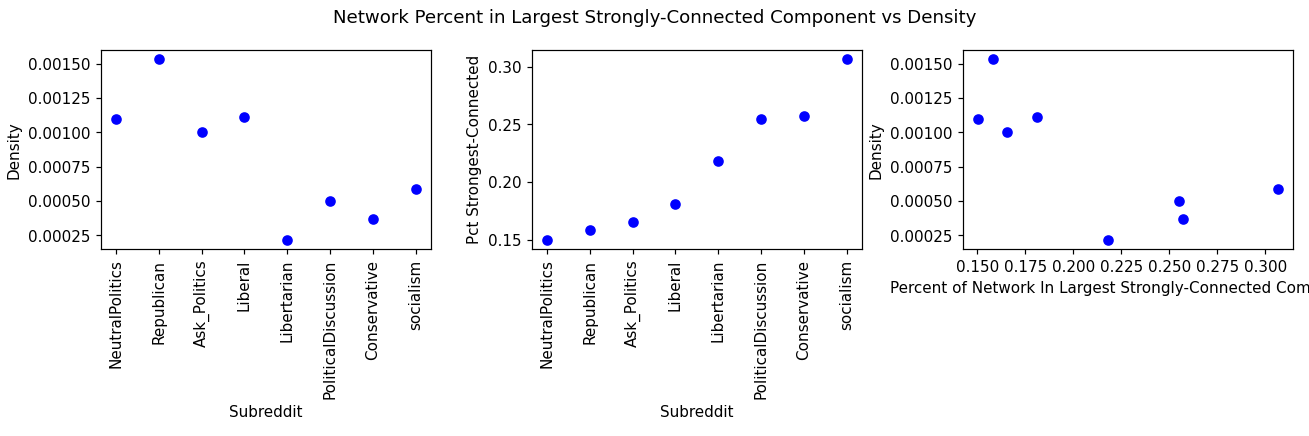

In [139]:
fig, (ax_dens, ax_strong, ax_vers) = plt.subplots(1, 3, figsize=(12,4))

In [137]:
sorted_params = params.sort_values(by=['pct_strongest_comp'])

In [140]:
fig.suptitle('Network Percent in Largest Strongly-Connected Component vs Density')
ax_dens.set_xlabel('Subreddit')
ax_dens.set_ylabel('Density')
ax_dens.set_xticklabels(sorted_params.index, rotation=90)
ax_dens.plot(sorted_params.index, sorted_params['density'], 'bo')

ax_strong.set_xlabel('Subreddit')
ax_strong.set_ylabel('Pct Strongest-Connected')
ax_strong.set_xticklabels(sorted_params.index, rotation=90)
ax_strong.plot(sorted_params.index, sorted_params['pct_strongest_comp'], 'bo')

ax_vers.set_xlabel('Percent of Network In Largest Strongly-Connected Component')
ax_vers.set_ylabel('Density')
ax_vers.plot(sorted_params['pct_strongest_comp'], sorted_params['density'], 'bo')

plt.tight_layout()
plt.show()

/tmp/ipykernel_18294/2879193650.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_dens.set_xticklabels(sorted_params.index, rotation=90)
/tmp/ipykernel_18294/2879193650.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_strong.set_xticklabels(sorted_params.index, rotation=90)


In [141]:
plt.savefig('images/pct-strong-vs-density.png', bbox_inches='tight')

#### NOTE:
Seems to be some correlation between network density and percent of nodes inside strongest-connected component

In [39]:
def count_deg_one_nodes(graphs, node_count, pct=True):
    """
    Return amount (or percentage of total) of nodes with in-degree + out-degree of 1
    """
    degrees = {n: nx.degree(g) for n, g in graphs.items()}
    
    # Counting amount of lowest degree nodes (1 in this case)
    singles = Counter()
    for sr, degs in degrees.items():
        for user, deg in degs:
            if deg == 1:
                singles[sr] += 1
                
    if pct:
        pct_singles = dict()
        for sr, count in node_count.items():
            pct_singles[sr] = singles[sr]/node_count[sr]
        
        return pct_singles
                
    return singles

In [40]:
singles = count_deg_one_nodes(graphs, nodes, False)
singles

Counter({'PoliticalDiscussion': 1343,
         'Ask_Politics': 587,
         'Republican': 369,
         'Libertarian': 3001,
         'Conservative': 1824,
         'NeutralPolitics': 385,
         'Liberal': 529,
         'socialism': 1190})

In [41]:
params['pct_deg_one_nodes'] = count_deg_one_nodes(graphs, nodes, True)
params.sort_values(by=['pct_deg_one_nodes'], ascending=False)

,density,strong_components,nodes,pct_strongest_comp,pct_deg_one_nodes
Liberal,0.00111,1542,2146,0.181267,0.246505
Republican,0.00153,1165,1543,0.158134,0.239145
Ask_Politics,0.00100,1821,2488,0.165193,0.235932
Conservative,0.00037,5970,8605,0.257176,0.211970
Libertarian,0.00022,11636,15901,0.218099,0.188730
socialism,0.00059,4209,6564,0.306520,0.181292
PoliticalDiscussion,0.00050,5885,8617,0.255193,0.155855
NeutralPolitics,0.00110,1838,2518,0.150119,0.152899


<IPython.core.display.Javascript object>


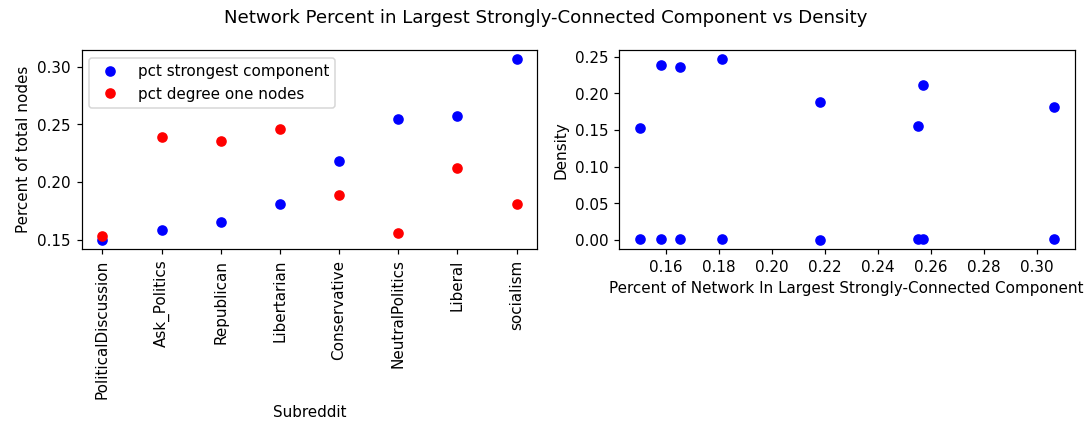

In [127]:
fig, (ax_indiv, ax_vers) = plt.subplots(1, 2, figsize=(10,4))

In [128]:
sorted_params = params.sort_values(by=['pct_strongest_comp'])

In [129]:
fig.suptitle('Ratio of Strongest-Connected Component vs One-degree Nodes')
ax_indiv.set_xlabel('Subreddit')
ax_indiv.set_ylabel('Percent of total nodes')
ax_indiv.set_xticklabels(params.index, rotation=90)
ax_indiv.plot(sorted_params.index, sorted_params['pct_strongest_comp'], 'bo')
ax_indiv.plot(sorted_params.index, sorted_params['pct_deg_one_nodes'], 'ro')
ax_indiv.legend(['pct strongest component', 'pct degree one nodes'])

ax_vers.set_xlabel('Pct Strongest-Connected')
ax_vers.set_ylabel('Pct Degree One')
ax_vers.plot(sorted_params['pct_strongest_comp'], sorted_params['pct_deg_one_nodes'], 'bo')

plt.tight_layout()
plt.show()

/tmp/ipykernel_18294/3677859951.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_indiv.set_xticklabels(params.index, rotation=90)


In [130]:
plt.savefig('images/pct-strong-vs-pct-deg-one.png', bbox_inches='tight')

### NOTE:
Seems to be some correlation between strongest-connected component membership and amount of degree one nodes.

The measured statistics need to be compared to their random graph counterparts to assess statistical significance.

## Centrality

Considering that every node in the dataset constitutes top ~20% of Redditors from 2014, it seems better to use Katz centrality, in order to ensure no node is labeled irrelevant. But, don't want to assign high centrality just by association with "important" nodes, therefore will use PageRank.

In [42]:
def get_pagerank_max_avg(graphs):
    """
    Return a tuple of (PageRank max value, PageRank average value) for the network
    """
    pagerankings = {n: nx.pagerank(g) for n,g in graphs.items()}
    
    pr_max = {n: max(r.values()) for n,r in pagerankings.items()}
    pr_avg = {n: np.average(list(r.values())) for n,r in pagerankings.items()}
    
    return pr_max, pr_avg

In [43]:
pagerankings = {n: nx.pagerank(g) for n,g in graphs.items()}
pr_max, pr_avg = get_pagerank_max_avg(graphs)

In [44]:
params['pagerank_max'] = pr_max
params['pagerank_avg'] = pr_avg

In [45]:
params.sort_values(by=['pagerank_max'], ascending=False)

,density,strong_components,nodes,pct_strongest_comp,pct_deg_one_nodes,pagerank_max,pagerank_avg
Republican,0.00153,1165,1543,0.158134,0.239145,0.038785,0.000648
NeutralPolitics,0.00110,1838,2518,0.150119,0.152899,0.035894,0.000397
Ask_Politics,0.00100,1821,2488,0.165193,0.235932,0.020196,0.000402
Conservative,0.00037,5970,8605,0.257176,0.211970,0.018490,0.000116
socialism,0.00059,4209,6564,0.306520,0.181292,0.014605,0.000152
Liberal,0.00111,1542,2146,0.181267,0.246505,0.014467,0.000466
PoliticalDiscussion,0.00050,5885,8617,0.255193,0.155855,0.010399,0.000116
Libertarian,0.00022,11636,15901,0.218099,0.188730,0.008555,0.000063


<IPython.core.display.Javascript object>


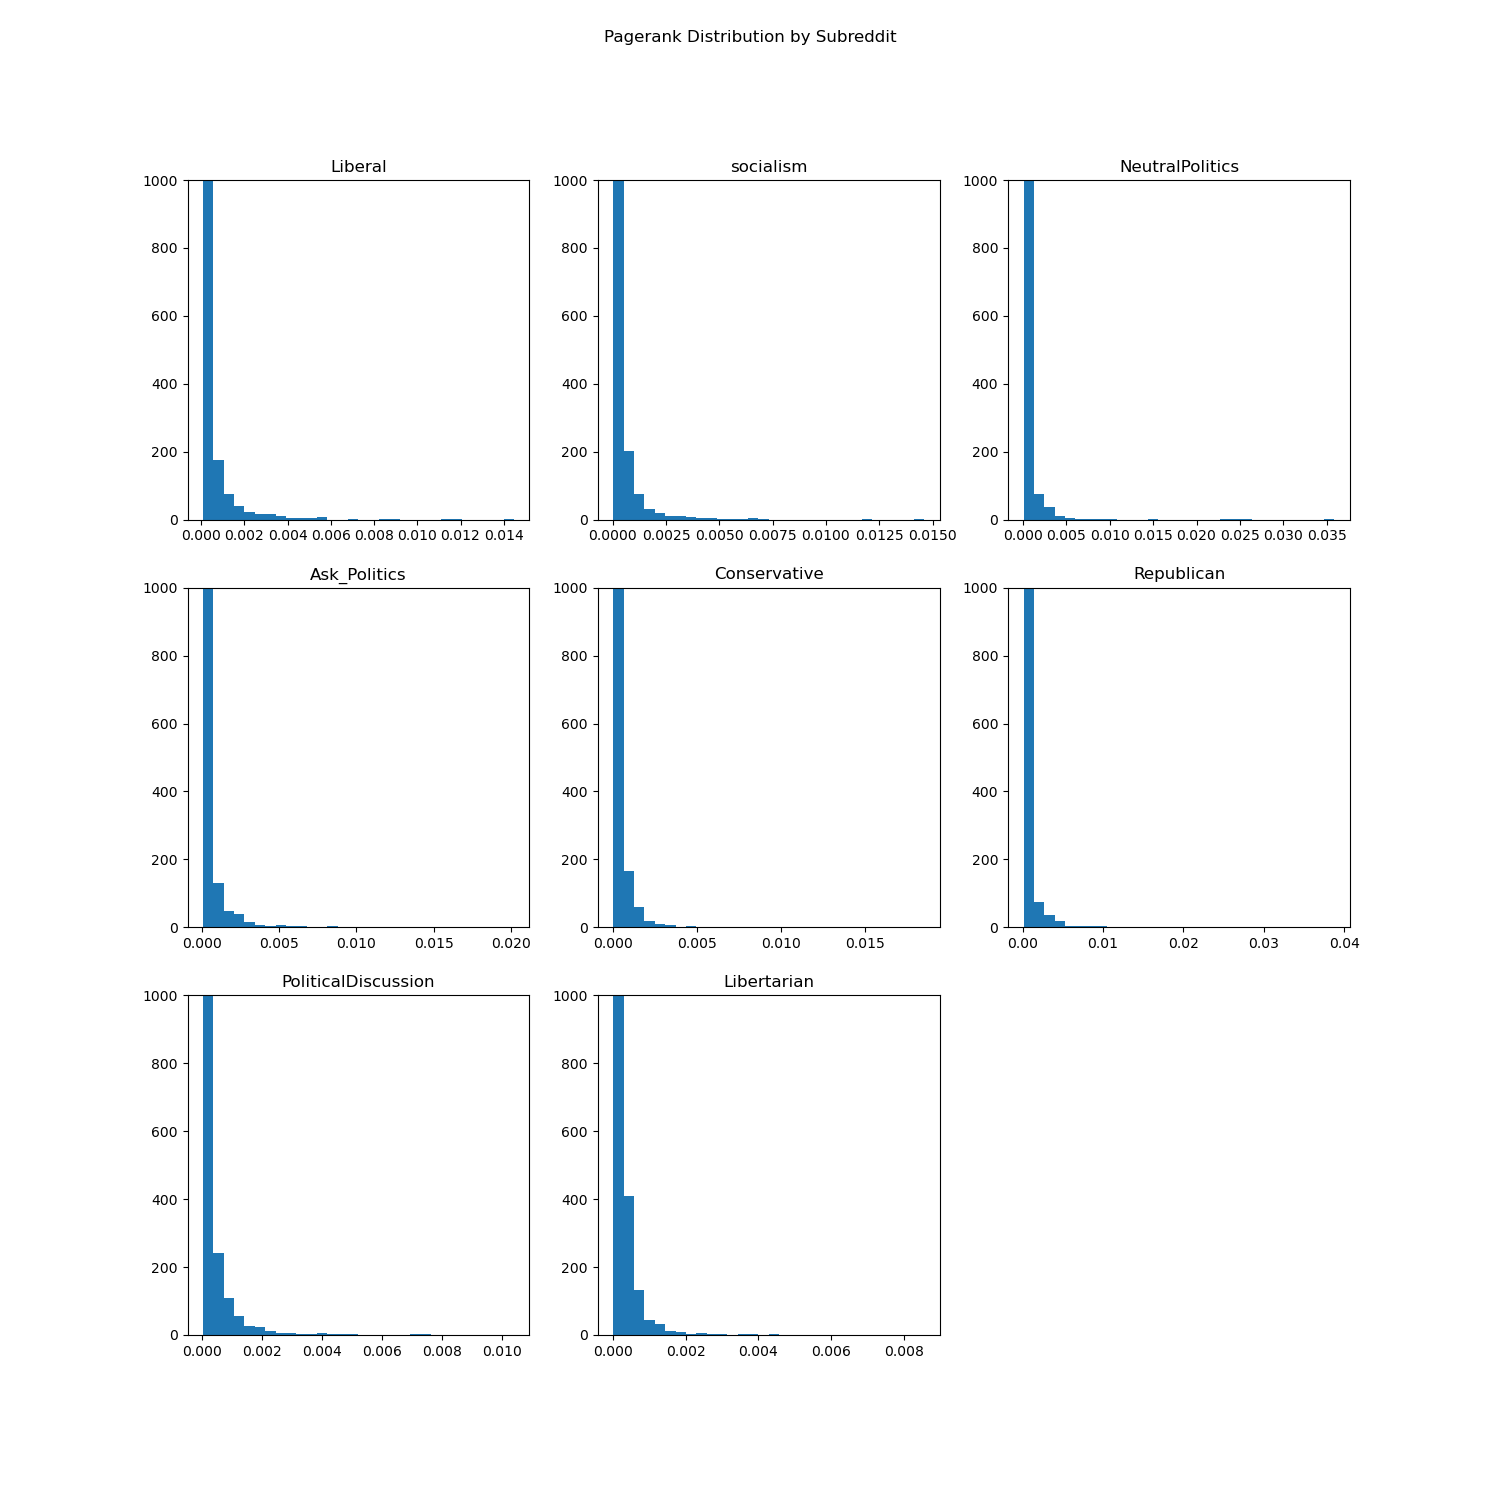

In [48]:
fig = plt.figure(figsize=(15,15))

In [53]:
plt.clf()
for i, (sr, pageranks) in enumerate(pagerankings.items()):
    fig.suptitle('Pagerank Distribution by Subreddit')
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(sr)
    ax.set_ylim(ymax=1000)
    
    ax.hist(pageranks.values(), bins=30)
    
plt.show()

### NOTE:
The distribution of the pagerank is obviously right-skewed, with no clear distinctions between the subreddits

## Reciprocity
The final measure I will compute is the reciprocity of the nodes in the network; the percent of nodes that have back and forth communication in subreddits (represented by edges in both directions). This could be used as a measure of presence of dialogue as opposed to simple posts.

In [46]:
reciproc = {n: nx.reciprocity(g) for n,g in graphs.items()}
params['reciprocity'] = reciproc
params.sort_values(by=['reciprocity'], ascending=False)

,density,strong_components,nodes,pct_strongest_comp,pct_deg_one_nodes,pagerank_max,pagerank_avg,reciprocity
PoliticalDiscussion,0.00050,5885,8617,0.255193,0.155855,0.010399,0.000116,0.211281
socialism,0.00059,4209,6564,0.306520,0.181292,0.014605,0.000152,0.209283
Liberal,0.00111,1542,2146,0.181267,0.246505,0.014467,0.000466,0.198904
Ask_Politics,0.00100,1821,2488,0.165193,0.235932,0.020196,0.000402,0.194269
Republican,0.00153,1165,1543,0.158134,0.239145,0.038785,0.000648,0.190450
NeutralPolitics,0.00110,1838,2518,0.150119,0.152899,0.035894,0.000397,0.175499
Libertarian,0.00022,11636,15901,0.218099,0.188730,0.008555,0.000063,0.165916
Conservative,0.00037,5970,8605,0.257176,0.211970,0.018490,0.000116,0.140227


<IPython.core.display.Javascript object>


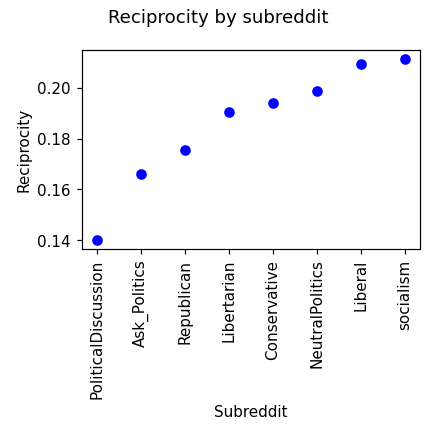

In [113]:
fig, ax = plt.subplots(figsize=(4,4))

In [111]:
sorted_params = params.sort_values(by=['reciprocity'])

In [114]:
fig.suptitle('Reciprocity by subreddit')

ax.set_xlabel('Subreddit')
ax.set_ylabel('Reciprocity')
ax.set_xticklabels(params.index, rotation=90)
ax.plot(sorted_params.index, sorted_params['reciprocity'], 'bo')

plt.tight_layout()
plt.show()

/tmp/ipykernel_18294/3778020643.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(params.index, rotation=90)


In [115]:
plt.savefig('images/reciprocity.png', bbox_inches='tight')

### NOTE:
Looks like left and right-wing subreddits are on the opposite spectrums, with highest reciprocity on the liberal side. There also seems to be some correlation between strongest-connected component membership and reciprocity (which would make sense since you are more likely to get a reply back and have a discussion if you are part of an existing community). It would be interesting to examine the largest strongly-connected component separately. 

## Probabilities Against Random Graphs
Calculating the P-values of the observed statistics using the configuration model to mimick the degree distribution. Statistics to sample for: 
<ul>
    <li>percent in strongest-connected component</li>
    <li>percent degree one nodes</li>
    <li>maximum pagerank</li>
    <li>average pagerank</li>
    <li>reciprocity</li>
</ul>.

In [71]:
in_degrees = {n: dict(g.in_degree()).values() for n,g in graphs.items()}
out_degrees = {n: dict(g.out_degree()).values() for n,g in graphs.items()}

In [76]:
fig = plt.figure(figsize=(15,9))

<IPython.core.display.Javascript object>

In [80]:
plt.clf()
for i, (sr, degrees) in enumerate(in_degrees.items()):
    fig.suptitle('Degree Distributions')
    ax_in = fig.add_subplot(3,6,i*2+1)
    ax_out = fig.add_subplot(3,6,i*2+2)
    ax_in.set_title(f'{sr} (in)')
    ax_in.set_xlim(xmax=100)
    ax_in.set_ylim(ymax=1000)
    ax_out.set_title(f'{sr} (out)')
    ax_out.set_xlim(xmax=100)
    ax_out.set_ylim(ymax=1000)
    
    ax_in.hist(degrees, bins=30)
    ax_out.hist(degrees, bins=30, color='g')

plt.tight_layout()
plt.show()

In [81]:
plt.savefig('images/degree_distribution.png', bbox_inches='tight')

In [151]:
sample_pct_strong_comps = {n: list() for n in params.index}
sample_pct_deg_one = {n: list() for n in params.index}
sample_pr_max = {n: list() for n in params.index}
sample_pr_avg = {n: list() for n in params.index}
sample_reciproc = {n: list() for n in params.index}

In [152]:
for i in range(1000):
    if i%10 == 0:
        print(f'***Resampled {i}')
    
    config_models = dict()
    
    for sr in graphs.keys():
        config_models[sr] = nx.directed_configuration_model(
            in_degrees[sr],
            out_degrees[sr],
            seed=i # To be able to later recreate, will use the index as random generator seed
        )
    
    pct_strong_comps = count_strongest_comp(config_models, nodes, True)
    pct_deg_one = count_deg_one_nodes(config_models, nodes, True)
    pr_max, pr_avg = get_pagerank_max_avg(config_models)
    reciproc = {n: nx.reciprocity(g) for n,g in config_models.items()}
    
    for sr in graphs.keys():
        sample_pct_strong_comps[sr].append(pct_strong_comps[sr])
        sample_pct_deg_one[sr].append(pct_deg_one[sr])
        sample_pr_max[sr].append(pr_max[sr])
        sample_pr_avg[sr].append(pr_avg[sr])
        sample_reciproc[sr].append(reciproc[sr])

***Resampled 0
***Resampled 10
***Resampled 20
***Resampled 30
***Resampled 40
***Resampled 50
***Resampled 60
***Resampled 70
***Resampled 80
***Resampled 90
***Resampled 100
***Resampled 110
***Resampled 120
***Resampled 130
***Resampled 140
***Resampled 150
***Resampled 160
***Resampled 170
***Resampled 180
***Resampled 190
***Resampled 200
***Resampled 210
***Resampled 220
***Resampled 230
***Resampled 240
***Resampled 250
***Resampled 260
***Resampled 270
***Resampled 280
***Resampled 290
***Resampled 300
***Resampled 310
***Resampled 320
***Resampled 330
***Resampled 340
***Resampled 350
***Resampled 360
***Resampled 370
***Resampled 380
***Resampled 390
***Resampled 400
***Resampled 410
***Resampled 420
***Resampled 430
***Resampled 440
***Resampled 450
***Resampled 460
***Resampled 470
***Resampled 480
***Resampled 490
***Resampled 500
***Resampled 510
***Resampled 520
***Resampled 530
***Resampled 540
***Resampled 550
***Resampled 560
***Resampled 570
***Resampled 580
***Resam

In [169]:
params

,density,strong_components,nodes,pct_strongest_comp,pct_deg_one_nodes,pagerank_max,pagerank_avg,reciprocity
Liberal,0.00111,1542,2146,0.181267,0.246505,0.014467,0.000466,0.198904
socialism,0.00059,4209,6564,0.306520,0.181292,0.014605,0.000152,0.209283
NeutralPolitics,0.00110,1838,2518,0.150119,0.152899,0.035894,0.000397,0.175499
Ask_Politics,0.00100,1821,2488,0.165193,0.235932,0.020196,0.000402,0.194269
Conservative,0.00037,5970,8605,0.257176,0.211970,0.018490,0.000116,0.140227
Republican,0.00153,1165,1543,0.158134,0.239145,0.038785,0.000648,0.190450
PoliticalDiscussion,0.00050,5885,8617,0.255193,0.155855,0.010399,0.000116,0.211281
Libertarian,0.00022,11636,15901,0.218099,0.188730,0.008555,0.000063,0.165916


In [188]:
def get_p_value(params, samples, field):
    p_vals = dict()
    
    for sr, stat in samples.items():
        portion_lt = params.loc[sr, field] > np.array(stat)
        portion_gt = params.loc[sr, field] < np.array(stat)
        
        # Use the smaller of the portion values as we're looking for min p-value
        portion = min(sum(portion_lt), sum(portion_gt))
        
        # 1000 was the size of the resamples -- shouldn't be hardcoded but done for sake of time
        p_vals[sr] = portion/1000
    
    return p_vals

In [189]:
p_val_strong = get_p_value(params, sample_pct_strong_comps, 'pct_strongest_comp')
p_val_deg_one = get_p_value(params, sample_pct_deg_one, 'pct_deg_one_nodes')
p_val_pr_max = get_p_value(params, sample_pr_max, 'pagerank_max')
p_val_pr_avg = get_p_value(params, sample_pr_avg, 'pagerank_avg')
p_val_recip = get_p_value(params, sample_reciproc, 'reciprocity')

### NOTE:
Degree one distribution obviously doesn't work when using the configuration model as you specify the degree distribution. The mean average page rank distribution being exactly the same was initially surprising but I believe the issue is the same as for the degree one distribution.

<IPython.core.display.Javascript object>


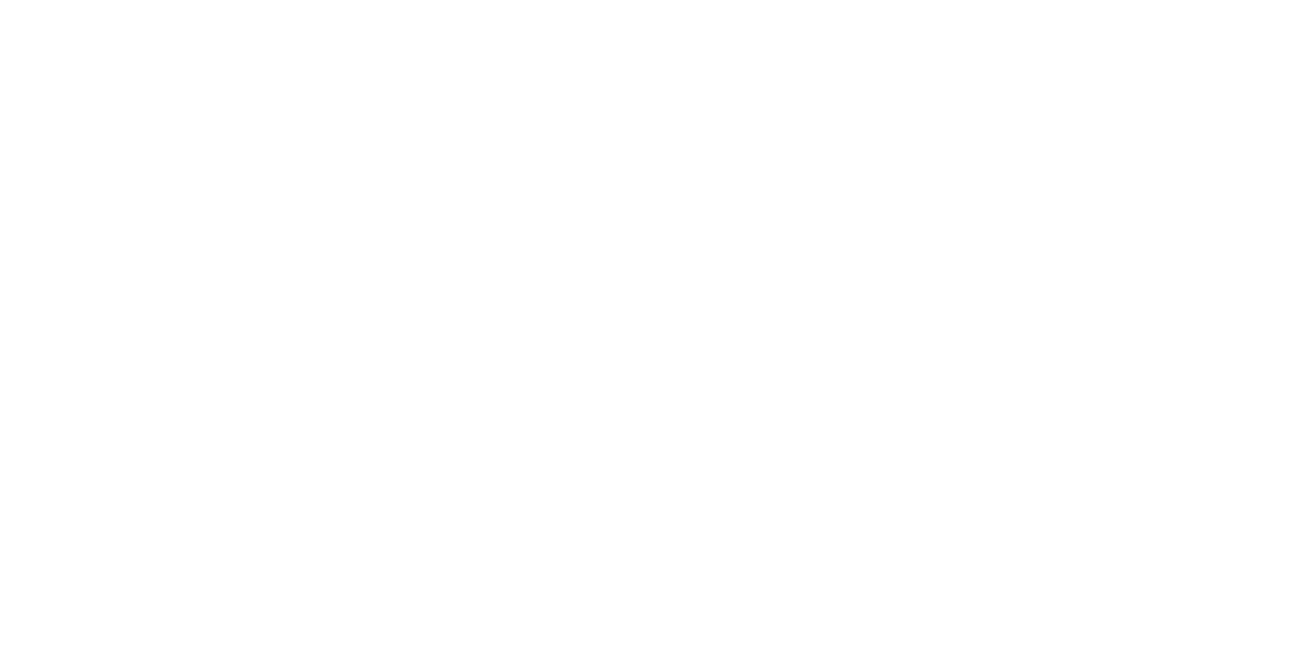

In [208]:
fig = plt.figure(figsize=(12,6))

In [192]:
plt.clf()
for i, (sr, pct) in enumerate(sample_pct_strong_comps.items()):
    fig.suptitle('Distribution of Percent of Nodes Inside Strongest-Connected Component')
    ax = fig.add_subplot(2,4,i+1)
    ax.set_title(f'{sr} (P: {np.round(p_val_strong[sr], 5)})')
    ax.set_ylim(ymax=300)
    
    ax.hist(pct)
    ax.axvline(params.loc[sr, 'pct_strongest_comp'], color='r')
    
plt.tight_layout()
plt.show()

In [193]:
plt.savefig('images/p-strong-comp.png', bbox_inches='tight')

## Excuse the ugly copy paste, done for sake of time

<IPython.core.display.Javascript object>


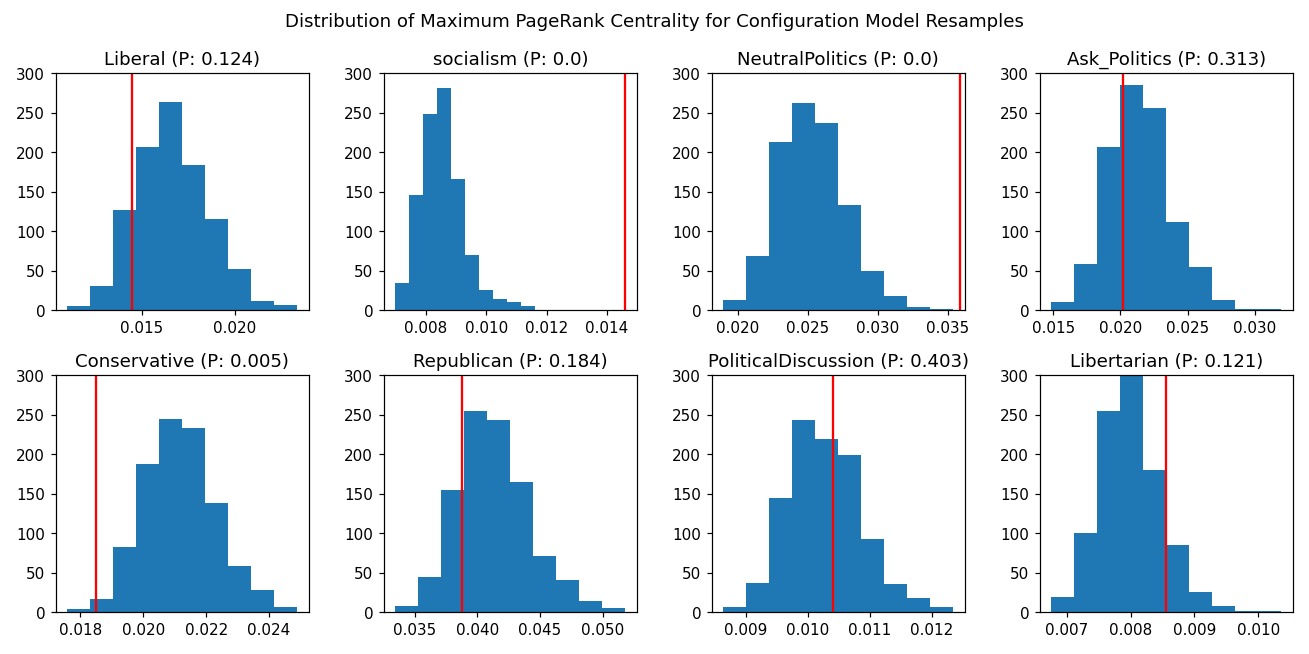

In [200]:
fig = plt.figure(figsize=(12,6))

In [201]:
plt.clf()
for i, (sr, pct) in enumerate(sample_pr_max.items()):
    fig.suptitle('Distribution of Maximum PageRank Centrality for Configuration Model Resamples')
    ax = fig.add_subplot(2,4,i+1)
    ax.set_title(f'{sr} (P: {np.round(p_val_pr_max[sr], 5)})')
    ax.set_ylim(ymax=300)
    
    ax.hist(pct)
    ax.axvline(params.loc[sr, 'pagerank_max'], color='r')
    
plt.tight_layout()
plt.show()

In [202]:
plt.savefig('images/p-pagerank-max.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


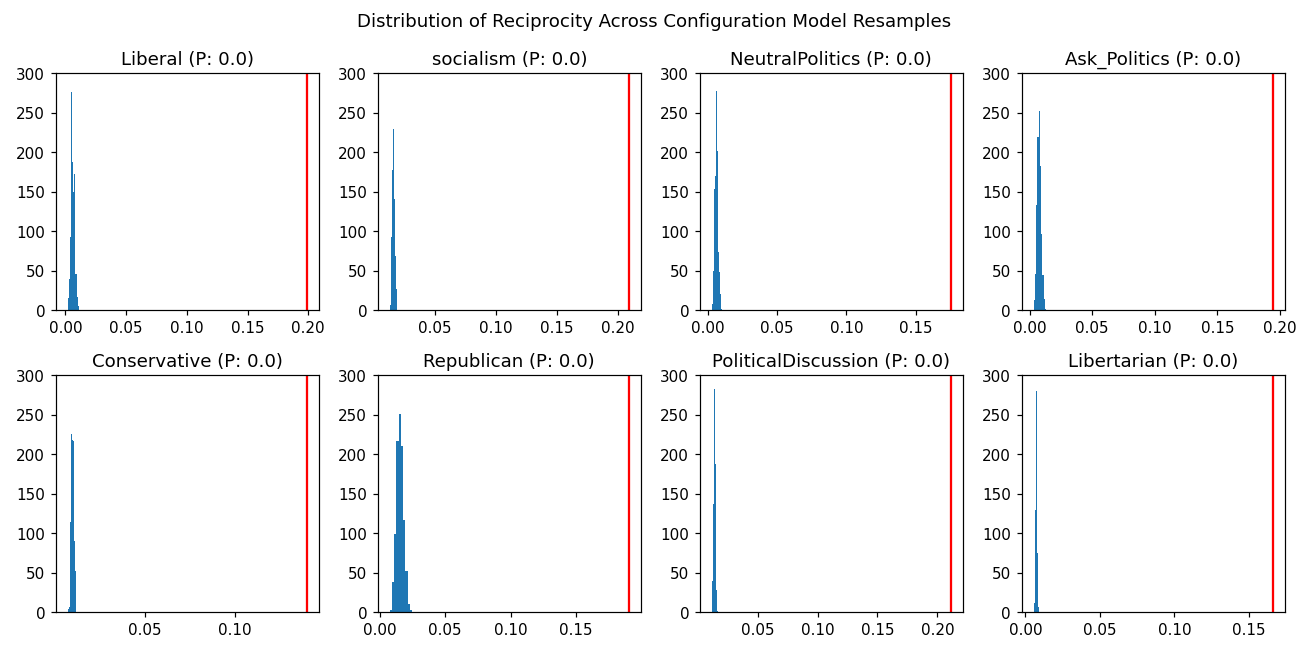

In [205]:
fig = plt.figure(figsize=(12,6))

In [206]:
plt.clf()
for i, (sr, pct) in enumerate(sample_reciproc.items()):
    fig.suptitle('Distribution of Reciprocity Across Configuration Model Resamples')
    ax = fig.add_subplot(2,4,i+1)
    ax.set_title(f'{sr} (P: {np.round(p_val_recip[sr], 5)})')
    ax.set_ylim(ymax=300)
    
    ax.hist(pct)
    ax.axvline(params.loc[sr, 'reciprocity'], color='r')
    
plt.tight_layout()
plt.show()

In [207]:
plt.savefig('images/p-reciprocity.png', bbox_inches='tight')